# Implementing a CNN module from scratch using the unfold function in PyTorch

In [1]:
from fastai2.vision.all import *

In [2]:
from collections.abc import Iterable

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

## What is unfold

In PyTorch, `unfold` and `fold` are to perform sliding window operations. It extracts sliding sliding local blocks from a batched input tensor.

![CNN illustration (source:Stanford CS 230)](https://stanford.edu/~shervine/teaching/cs-230/illustrations/convolution-layer-a.png?1c517e00cb8d709baf32fc3d39ebae67)

In the illustration above, we have `3x3` kernel being applied to a `6x6` image to produce a `4x4` feature map. With a slide of 1 and no padding, there are **16** `3x3` patches in the input image ie. the kernel moves 16 times across the image each time producing a single output. However, at each patch, there are **9** values (pixels) in the image that are being convolved with the kernel. Emphasis has been placed on **16** and **9** because applying unfold with a `3x3` kernel to this image would produce an output of `1x9x16`, where:

- 16 = the number of `kernel size` blocks in the input image, taking into consideration sliding and and the amount of padding
- 9 = the total number of values within each `kernel size` block
- 1 = batch size

The number of values in each is `9` in this case because our input has only one channel. If our input was a 4-channel image, then the total number of values within each block would be `4.3.3 = 36`. For example the image below is a 3-channel image with a `2x2` kernel and so at each block we have **12** input values ie. 4 from each channel. 

![3-channel image](images/cnn1.png)

#### Let's demonstrate this on an real image

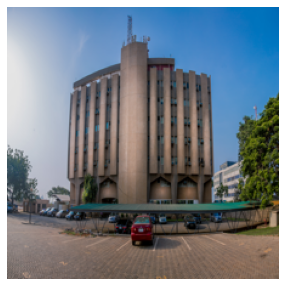

In [33]:
img = PILImage.create('images/gnpc.jpg')
img = img.resize((224, 224))
show_image(img)

In [43]:
# reshape image to channel first ordering
img_tensor = tensor(img).float().T
img_tensor.shape

torch.Size([3, 224, 224])

Initialize unfold object with a kernel size of `3x3` no padding and a stride of 1

In [37]:
unfold = nn.Unfold((3,3), padding=0, stride=1)

The size of our image is `3x224x224` which is going to be unfolded with a `3x3` kernel. This means that at each patch there are `27` values. With this the CNN output formula:
$$\frac {n+2p-k}{s} -1$$
We can find that, the size of the output will be `222x222`. Hence the number of `3x3` blocks (patches) within the image would be `49284` ie. $222^2$.

In [98]:
# insert empty batch dimension and apply unfold
im_unf = unfold(img_tensor[None]) 
im_unf.shape # size of output

torch.Size([1, 27, 49284])

Create a weight matrix, for simplicity let's have three output feature maps

In [99]:
# shape of weight matrix is : out_channels * in_channels * kernel_size
weights = torch.randn((3, 3, 3, 3))

Reshape the results of unfolding into a more intuitive view, new shape is: **batch_size x number_of_blocks x number_of_values_in_each_block**

In [100]:
im_unf.transpose_(1,2)
im_unf.shape

torch.Size([1, 49284, 27])

In [101]:
convolve = im_unf @ weights.view(weights.shape[0], -1).T
convolve.shape

torch.Size([1, 49284, 3])

In [102]:
fold = nn.Fold((222, 222), (1, 1))

In [103]:
results = fold(convolve.transpose(1,2))
results.shape

torch.Size([1, 3, 222, 222])

In [105]:
e = results.squeeze(0).byte().T

In [106]:
e.shape

torch.Size([222, 222, 3])

In [107]:
e.type()

'torch.ByteTensor'

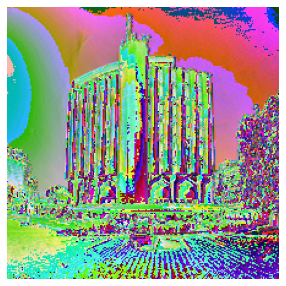

In [108]:
a = PILImageBW.create(e)
a.show()

In [ ]:
res

## Real

**check how bias works and add bias**

In [13]:
class MyConv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels, self.out_channels = in_channels, out_channels
        self.kernel_size = self._pair(kernel_size)
        self.stride, self.padding = stride, padding
        
        # fan in for weight initialization
        fan_in = torch.tensor(in_channels * self.kernel_size[0] * self.kernel_size[1], dtype=float)
        # use kaiming initialization
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels, *self.kernel_size)) * torch.sqrt(2/fan_in))
        
        # add bias
        self.bias = nn.Parameter(torch.zeros(out_channels))
    def forward(self, x):
        assert(x.shape[1] == self.in_channels)
        unf = F.unfold(x, self.kernel_size, padding=self.padding, stride=self.stride)
        # reshape
        unf.transpose_(1, 2)
        # convolve image with the filters
        conv = (unf @ self.weight.view(self.weight.shape[0], -1).T + self.bias).transpose(1, 2)
        
        # fold back to appropriate size
        oz = self.output_size(x.shape[2], x.shape[3])
        return F.fold(conv, oz, (1,1))
        
    def output_size(self, x_r, x_c):
        oz_r = self.cal_output_dim(x_r, self.kernel_size[0])
        # check if the image and filters are square
        if x_r == x_c and self.kernel_size[0] == self.kernel_size[1]:
            return oz_r, oz_r
        oz_c = self.cal_output_dim(x_c, self.kernel_size[1])
        return oz_r, oz_c
    
    def cal_output_dim(self, n, kernel_size):
        return (n + 2 * self.padding - kernel_size) // self.stride + 1
        
    def _pair(self, k):
        # utility function to allow the use of a single integer for the kernel size
        if isinstance(k, Iterable):
            return k
        return tuple((k, k))

In [14]:
my_conv1 = MyConv2d(3, 16, 3)

In [15]:
im = torch.randn((1, 3, 28, 28))

In [16]:
res = my_conv1(im)

In [17]:
res.shape

torch.Size([1, 16, 26, 26])

## Train model with it

In [18]:
path = untar_data(URLs.MNIST)

Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [19]:
(path/'testing').ls()

(#10) [Path('testing/0'),Path('testing/2'),Path('testing/9'),Path('testing/8'),Path('testing/7'),Path('testing/1'),Path('testing/5'),Path('testing/4'),Path('testing/6'),Path('testing/3')]

In [20]:
mnist = DataBlock(
            blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
            get_items=get_image_files,
            splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
            get_y=parent_label)

In [21]:
dls = mnist.dataloaders(path)

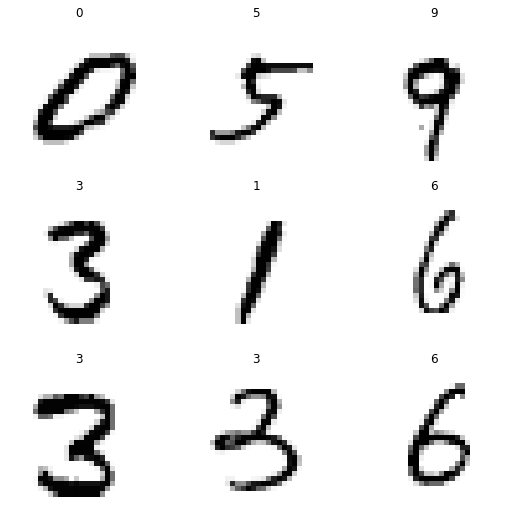

In [22]:
dls.show_batch()

In [23]:
dls.c

10

In [33]:
model = nn.Sequential(
            MyConv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            MyConv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            MyConv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            MyConv2d(32, 64, 3, stride=2, padding=1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, dls.c))

In [34]:
learn = Learner(dls, model, metrics=error_rate)

In [35]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.177968,1.107222,0.383900,00:32
1,0.694842,0.644660,0.212800,00:27
2,0.437660,0.393045,0.121000,00:26
3,0.352365,0.308798,0.091800,00:26
4,0.293147,0.264723,0.078600,00:26
5,0.245503,0.215906,0.067000,00:26
6,0.202867,0.203328,0.063300,00:28
7,0.203440,0.187460,0.057200,00:26
8,0.177090,0.178234,0.054600,00:26
9,0.185658,0.176034,0.053000,00:26


## stop using nn.Parameter and implement backprop from scratch

In [21]:
cnn_learner?

Object `cnn_learner` not found.


In [ ]:
from fastai2.vision import cnn_